# Download forced photometry lightcurves from DB

Columns to be used:
- For epoch: `mjd`
- For filter: `filter` (g, r, i) or `fid` (1, 2, 3)
- For apparent magnitude: `mag_tot`
- For apparent magnitude uncertainty: `sigma_mag_tot_resc`
- For difference magnitude: `mag_diff`, sign of difference given by `isdiffpos`
- For difference magnitude uncertainty: `sigma_mag_diff_resc`
- For total flux in uJy: `flux_tot_uJy`
- For total flux uncertainty in uJy: `fluxunc_tot_uJy_resc`
- For difference flux in uJy: `flux_diff_uJy`
- For difference flux uncertainty in uJy: `sigma_flux_diff_uJy_resc`

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import json
from astropy.time import Time
from config import db_credentials
import os
from tqdm import tqdm

In [2]:
conn = psycopg2.connect(
    host=db_credentials['host'],
    port=db_credentials['port'],
    user=db_credentials['user'],
    password=db_credentials['password'],
    database=db_credentials['database']
)

## Available classes:

In [3]:
available_classes = pd.read_sql(
    "SELECT DISTINCT alerceclass FROM object;",
    conn
)
available_classes

/tmp/ipykernel_17443/462451200.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  available_classes = pd.read_sql(


,alerceclass
0,SNIIn
1,DSCT
2,CV/Nova
3,RRLc
4,AGN
5,YSO
6,ZZ
7,TDE
8,EB/EW
9,Microlensing


## Small sample

In [ ]:
selected_classes = [
    'SNIa',
    'RRLab'
]

In [ ]:
objects_df = pd.read_sql(
    '''
    SELECT * 
    FROM object 
    WHERE alerceclass in (%s)
    ORDER BY ra
    LIMIT 10;
    ''' % ','.join(["'%s'" % alerce_class for alerce_class in selected_classes]),
    conn
)
objects_df

### Full sample

In [4]:
objects_df = pd.read_sql(
    '''
    SELECT * 
    FROM object
    ''',
    conn
)
objects_df

/tmp/ipykernel_17443/4165438931.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objects_df = pd.read_sql(


,oid,ra,dec,submitter,alerceclass
0,ZTF21aanrvaz,227.999259,-21.317113,amunoz,AGN
1,ZTF17aaazlzl,120.870621,33.462329,amunoz,AGN
2,ZTF21acqoruu,297.425121,3.303783,amunoz,AGN
3,ZTF22aaafnol,165.188738,62.921204,amunoz,AGN
4,ZTF22aaaokdq,219.567335,-6.972391,amunoz,AGN
...,...,...,...,...,...
41804,ZTF18abmecii,319.284338,34.207667,amunoz,ZZ
41805,ZTF21aciipaz,168.065773,11.295784,amunoz,ZZ
41806,ZTF21aaotzvw,180.441441,-3.761199,amunoz,ZZ
41807,ZTF18adbmine,26.841025,-21.947699,amunoz,ZZ


## Select the 'processed columns' that you want
The full list is:

'oid', 'index', 'mjd', 'nearestrefflux', 'flux_tot', 'flux_diff_ujy',
'sigma_flux_diff_ujy', 'flux_tot_ujy', 'fluxunc_tot', 'snr_tot',
'fluxunc_tot_ujy', 'mag_tot', 'sigma_mag_tot', 'mag_diff',
'sigma_mag_diff', 'isdiffpos', 'fid', 'secz', 'ccdquadid', 'zpthres',
'crit1', 'crit4', 'flag_bad', 'forcediffimfluxunc_resc',
'sigma_flux_diff_ujy_resc', 'fluxunc_tot_resc', 'fluxunc_tot_ujy_resc',
'snr_tot_resc', 'sigma_mag_diff_resc', 'sigma_mag_tot_resc'

'index' can be useful to match an 'original' observation with its corresponding processed version

In [5]:
processed_oids = pd.read_sql(
    '''
    SELECT DISTINCT oid
    FROM processed
    ''',
    conn
)
processed_oids

/tmp/ipykernel_17443/81217120.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  processed_oids = pd.read_sql(


,oid
0,ZTF21acasmne
1,ZTF19aaonuwr
2,ZTF17aabhkmn
3,ZTF18aatxhtl
4,ZTF18aaadfyl
...,...
41772,ZTF18aajbozk
41773,ZTF22aaabppe
41774,ZTF19abxnoad
41775,ZTF23aaqniyk


In [6]:
objects_df.set_index('oid', inplace=True)
objects_df.head()

,ra,dec,submitter,alerceclass
oid,,,,
ZTF21aanrvaz,227.999259,-21.317113,amunoz,AGN
ZTF17aaazlzl,120.870621,33.462329,amunoz,AGN
ZTF21acqoruu,297.425121,3.303783,amunoz,AGN
ZTF22aaafnol,165.188738,62.921204,amunoz,AGN
ZTF22aaaokdq,219.567335,-6.972391,amunoz,AGN


In [7]:
objects_df = objects_df.loc[processed_oids.values.flatten()]
objects_df.head()

,ra,dec,submitter,alerceclass
oid,,,,
ZTF21acasmne,291.414602,-14.603520,amunoz,CV/Nova
ZTF19aaonuwr,293.431251,21.348710,amunoz,LPV
ZTF17aabhkmn,86.770569,0.308770,amunoz,YSO
ZTF18aatxhtl,192.578746,43.709578,amunoz,QSO
ZTF18aaadfyl,156.578799,18.586220,amunoz,RSCVn


In [8]:
objects_df.shape

(41777, 4)

In [17]:
batch_size = 500
n_batches = int(np.ceil(len(objects_df)/batch_size))
for i_batch in tqdm(range(n_batches)):
    batch_oids = objects_df.index.values[i_batch*batch_size:(i_batch+1)*batch_size]
    lightcurves = pd.read_sql(
        '''
        SELECT oid, index, mjd, fid, mag_tot, sigma_mag_tot, flux_diff_ujy, sigma_flux_diff_ujy, detected
        FROM processed
        WHERE oid in (%s)
        ''' % ','.join(["'%s'" % oid for oid in batch_oids]),
        conn
    )
    lightcurves.to_parquet(
        os.path.join(
            'data_231206',
            f'lightcurves_batch_{i_batch:03}.parquet'
        )
    )

  0%|                                                                                                                                                                  | 0/84 [00:00<?, ?it/s]/tmp/ipykernel_17443/1075889747.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  lightcurves = pd.read_sql(
/home/ireyes/anaconda3/envs/pipeline/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [11:24<00:00,  8.15s/it]


In [ ]:
lightcurves = pd.read_sql(
    '''
    SELECT oid, index, mjd, fid, mag_tot, sigma_mag_tot, flux_diff_ujy, sigma_flux_diff_ujy, detected
    FROM processed
    WHERE oid in (%s)
    ''' % ','.join(["'%s'" % oid for oid in objects_df.index.values]),
    conn
)
lightcurves

## Let's do some plots

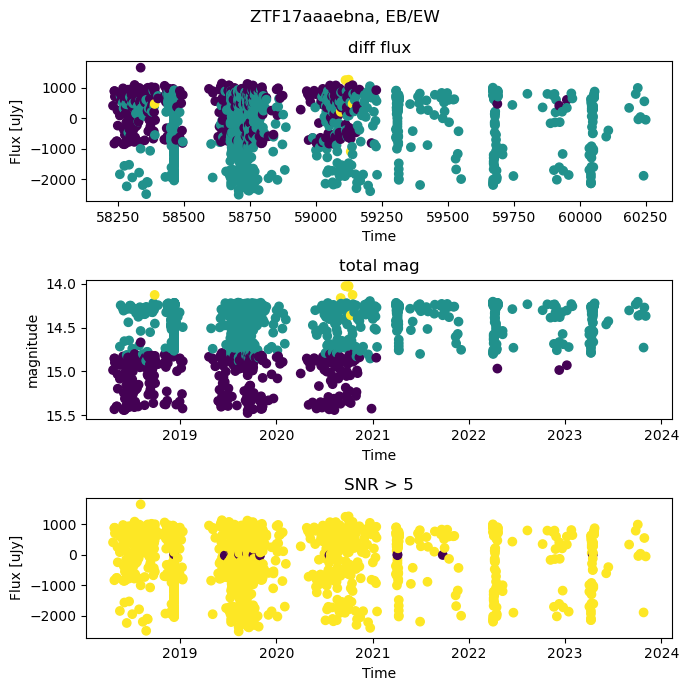

In [23]:
oid = lightcurves.oid.values[100]
lc = lightcurves[lightcurves.oid == oid]

fig = plt.figure(figsize=(7, 7))
fig.set_facecolor('white')
plt.suptitle(f'{oid}, {objects_df.loc[oid].alerceclass}')

time = Time(lc.mjd, format='mjd')

plt.subplot(3, 1, 1)
plt.scatter(lc.mjd, lc.flux_diff_ujy, c=lc.fid)
plt.xlabel('Time')
plt.ylabel('Flux [uJy]')
plt.title('diff flux')

plt.subplot(3, 1, 2)
plt.scatter(time.to_datetime(), lc.mag_tot, c=lc.fid)
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('magnitude')
plt.title('total mag')

plt.subplot(3, 1, 3)
plt.scatter(time.to_datetime(), lc.flux_diff_ujy, 
            c=(np.abs(lc.flux_diff_ujy / lc.sigma_flux_diff_ujy) > 5).astype(int))
plt.xlabel('Time')
plt.ylabel('Flux [uJy]')
plt.title('SNR > 5')

plt.tight_layout()

## Please save the lightcurves and object info to avoid downloading data from AWS over and over

In [24]:
objects_df.to_parquet('data_231206/objects.parquet')

/home/ireyes/anaconda3/envs/pipeline/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


## Lightcurve analysis (nan)

In [26]:
lightcurves.isna().mean(axis=0)

oid                    0.000000
index                  0.000000
mjd                    0.000000
fid                    0.000000
mag_tot                0.016511
sigma_mag_tot          0.008632
flux_diff_ujy          0.000000
sigma_flux_diff_ujy    0.000000
detected               0.000000
dtype: float64